In [1]:
import pandas as pd

# Load the cleaned dataset
file_path = "cleaned_CIC_IDS2017.csv"
df = pd.read_csv(file_path)

# Display dataset info and first few rows
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829385 entries, 0 to 2829384
Data columns (total 28 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0    Destination Port            int64  
 1    Flow Duration               int64  
 2    Total Fwd Packets           int64  
 3   Total Length of Fwd Packets  int64  
 4    Fwd Packet Length Max       int64  
 5    Fwd Packet Length Min       int64  
 6    Fwd Packet Length Mean      float64
 7   Bwd Packet Length Max        int64  
 8    Bwd Packet Length Min       int64  
 9   Flow Bytes/s                 float64
 10   Flow Packets/s              float64
 11   Flow IAT Mean               float64
 12   Flow IAT Std                float64
 13   Flow IAT Min                int64  
 14   Fwd IAT Min                 int64  
 15   Fwd Header Length           int64  
 16   Bwd Header Length           int64  
 17   Bwd Packets/s               float64
 18   Min Packet Length           int64  
 19  

In [2]:
df.columns = df.columns.str.strip()  


In [3]:
print(df["Label"].unique())  # Should print [0, 1]


[0 1]


In [4]:
print("Class distribution before outlier removal:\n", df["Label"].value_counts())


Class distribution before outlier removal:
 Label
0    2272688
1     556697
Name: count, dtype: int64


In [5]:
# Check dataset shape
print(f"Dataset shape: {df.shape}")

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

# Check class distribution
print("\nClass distribution:\n", df["Label"].value_counts())


Dataset shape: (2829385, 28)
Missing values per column:
 Series([], dtype: int64)

Class distribution:
 Label
0    2272688
1     556697
Name: count, dtype: int64


In [6]:
negative_counts = (df < 0).sum()
negative_counts = negative_counts[negative_counts > 0]  # Keep only columns with negative values
print("Columns with negative values and their count:\n", negative_counts)


Columns with negative values and their count:
 Flow Duration                  115
Flow Bytes/s                    85
Flow Packets/s                 115
Flow IAT Mean                  115
Flow IAT Min                  2890
Fwd IAT Min                     17
Fwd Header Length               35
Bwd Header Length               22
Init_Win_bytes_forward     1001189
Init_Win_bytes_backward    1440392
min_seg_size_forward            35
dtype: int64


In [7]:
# List of columns where negatives should be replaced with 0
replace_with_zero = [
    'Init_Win_bytes_backward', 'Init_Win_bytes_forward', 'min_seg_size_forward', 
    'Fwd Header Length', 'Bwd Header Length' ,'Flow Duration', 'Flow IAT Min'
]

# List of columns where negatives should be replaced with median
replace_with_median = [
    'Flow Bytes/s', 'Fwd IAT Min', 'Flow Packets/s', 'Flow IAT Mean'
]

# Replace negative values with 0
df[replace_with_zero] = df[replace_with_zero].clip(lower=0)

# Replace negative values with median
for col in replace_with_median:
    median_value = df[col].median()
    df[col] = df[col].apply(lambda x: median_value if x < 0 else x)


In [8]:
print(df["Label"].unique())  # Should print [0, 1]
print("Class distribution before outlier removal:\n", df["Label"].value_counts())


[0 1]
Class distribution before outlier removal:
 Label
0    2272688
1     556697
Name: count, dtype: int64


In [9]:
negative_counts = (df < 0).sum()
negative_counts = negative_counts[negative_counts > 0]  # Keep only columns with negative values
print("Columns with negative values and their count:\n", negative_counts)


Columns with negative values and their count:
 Series([], dtype: int64)


<Figure size 1500x1200 with 0 Axes>

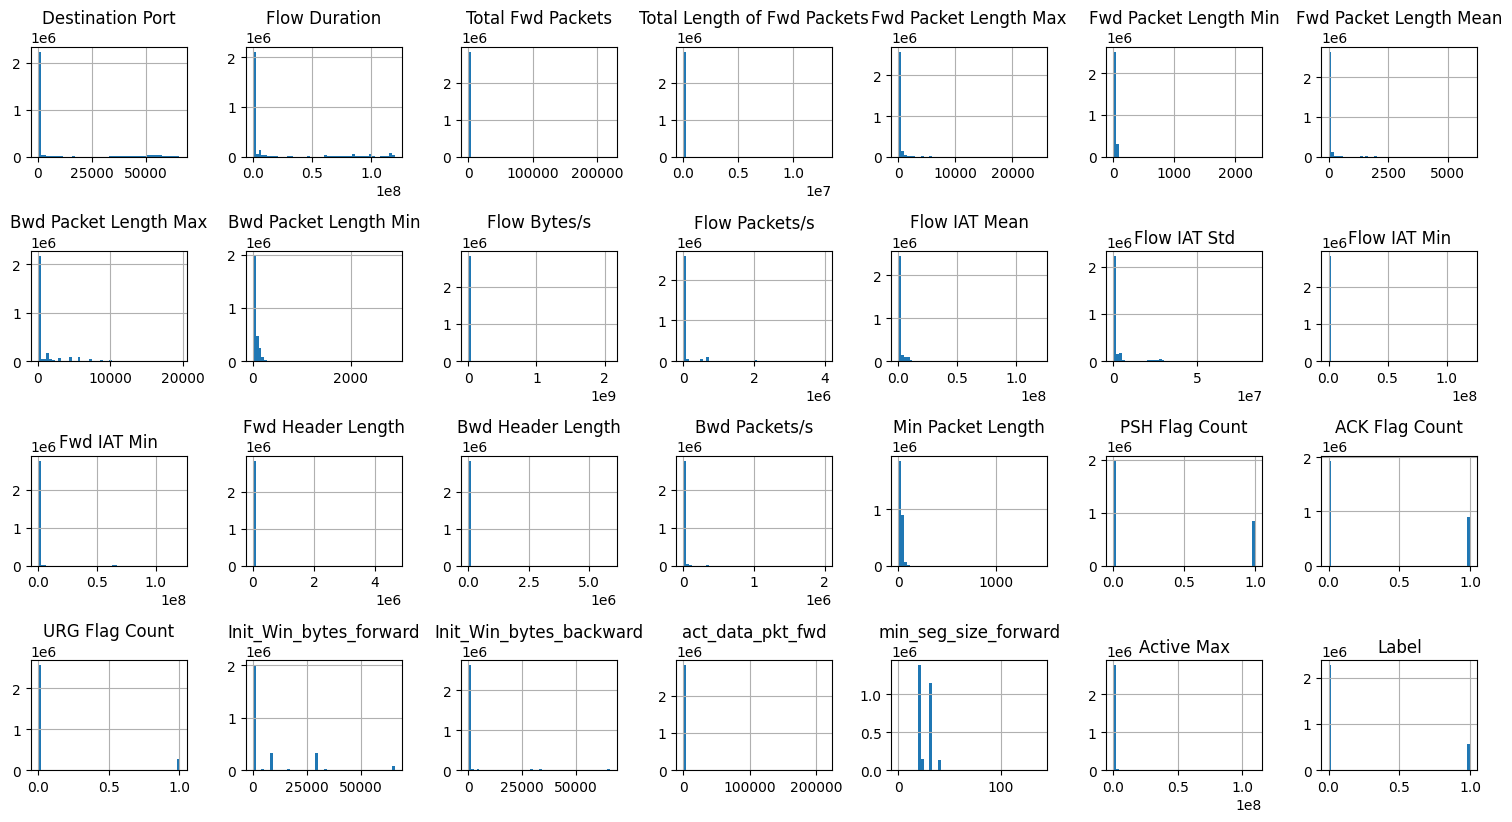

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select only numeric features
numeric_features = df.select_dtypes(include=[np.number])

# Plot histograms
plt.figure(figsize=(15, 12))
numeric_features.hist(bins=50, figsize=(15, 12), layout=(6, 7))  # Adjust rows/cols based on # of features
plt.tight_layout()
plt.show()


In [11]:
# Compute skewness of each feature
skewness = numeric_features.skew().sort_values(ascending=False)
print(skewness)


Total Length of Fwd Packets    805.378960
act_data_pkt_fwd               284.526957
Total Fwd Packets              244.321931
Fwd Header Length              243.457626
Bwd Header Length              243.413341
Flow Bytes/s                    46.409039
Active Max                      24.346149
Flow IAT Min                    23.782417
Bwd Packets/s                   21.484148
Fwd Packet Length Min           20.135303
Min Packet Length               10.193167
Fwd Packet Length Max            9.847005
Fwd IAT Min                      9.710320
Fwd Packet Length Mean           9.133782
Flow IAT Mean                    8.967770
Flow Packets/s                   5.560075
Init_Win_bytes_backward          5.251820
Bwd Packet Length Min            4.837439
Flow IAT Std                     3.610032
Bwd Packet Length Max            2.937473
URG Flag Count                   2.765649
Init_Win_bytes_forward           2.561913
Flow Duration                    2.154547
Destination Port                 2

In [12]:
print("Original shape:", df.shape)

Original shape: (2829385, 28)


In [13]:
# Compute IQR only on normal traffic (Label = 0)
Q1 = df[df["Label"] == 0][numeric_features.columns].quantile(0.25)
Q3 = df[df["Label"] == 0][numeric_features.columns].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Apply IQR filtering only to normal traffic
mask_normal = (df[df["Label"] == 0][numeric_features.columns] >= lower_bound) & \
              (df[df["Label"] == 0][numeric_features.columns] <= upper_bound)

df_filtered = pd.concat([df[df["Label"] == 1],  # Keep all attack traffic
                         df[df["Label"] == 0][mask_normal.all(axis=1)]])  # Filter normal traffic

print("Class distribution after outlier removal:\n", df_filtered["Label"].value_counts())


Class distribution after outlier removal:
 Label
1    556697
0    361818
Name: count, dtype: int64


<Figure size 1500x1200 with 0 Axes>

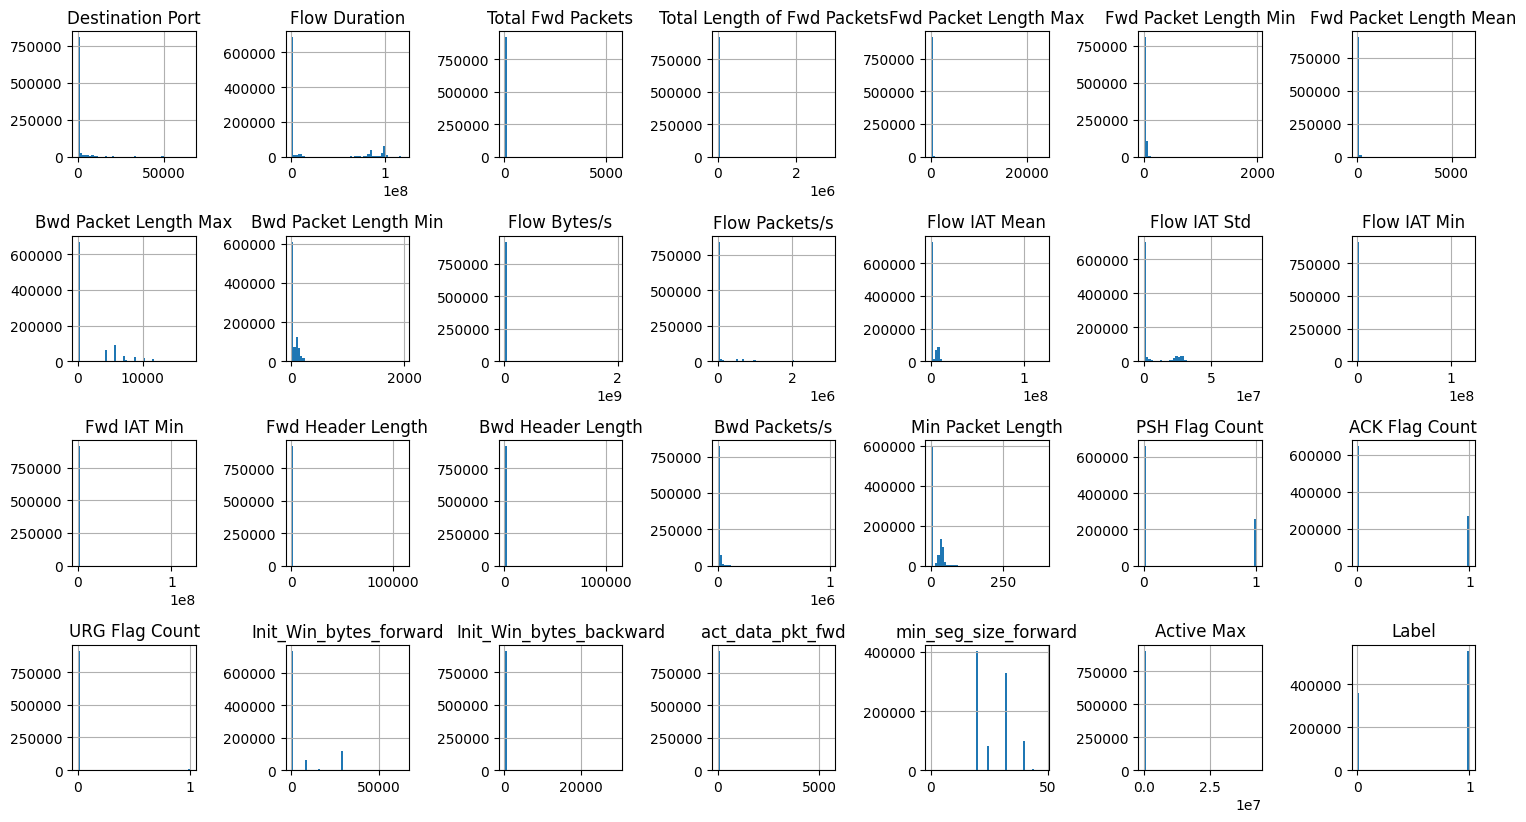

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select only numeric features from the filtered dataset
numeric_features_filtered = df_filtered.select_dtypes(include=[np.number])

# Plot histograms for the cleaned data
plt.figure(figsize=(15, 12))
numeric_features_filtered.hist(bins=50, figsize=(15, 12), layout=(6, 7))  # Adjust rows/cols based on features
plt.tight_layout()
plt.show()


In [15]:
# Find columns with negative values and their count in the cleaned dataset
negative_values_filtered = (df_filtered < 0).sum()
negative_columns_filtered = negative_values_filtered[negative_values_filtered > 0]

# Display columns with negative values and their count
print("Columns with negative values and their count (after outlier removal):")
print(negative_columns_filtered)


Columns with negative values and their count (after outlier removal):
Series([], dtype: int64)


DATA SCALING

In [16]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Selecting only feature columns (excluding the label column)
feature_columns = df_filtered.columns.difference(['Label'])

# Applying StandardScaler
df_filtered[feature_columns] = scaler.fit_transform(df_filtered[feature_columns])

# Verifying the transformation
print(df_filtered.head())  # Display first few rows
print(df_filtered.describe())  # Check if mean is ~0 and std is ~1


       Destination Port  Flow Duration  Total Fwd Packets  \
18880         -0.231126      -0.460231          -0.028374   
18881         -0.231126      -0.373133           0.041001   
18882         -0.231126      -0.466087          -0.028374   
18883         -0.231126       1.732558           0.318503   
18884         -0.231126      -0.478364          -0.028374   

       Total Length of Fwd Packets  Fwd Packet Length Max  \
18880                    -0.023884              -0.362516   
18881                    -0.024263              -0.442818   
18882                    -0.023884              -0.362516   
18883                    -0.018199              -0.362516   
18884                    -0.023884              -0.362516   

       Fwd Packet Length Min  Fwd Packet Length Mean  Bwd Packet Length Max  \
18880              -0.391557               -0.379451               1.369272   
18881              -0.230405               -0.430570              -0.581043   
18882              -0.391557 

HYBRID FEATURE SELECTION

In [17]:
from sklearn.feature_selection import VarianceThreshold

# Drop the target column
X_filtered = df_filtered.drop(columns=["Label"])

# Apply VarianceThreshold (removing features with variance below 0.01)
var_thresh = VarianceThreshold(threshold=0.01)
X_var = var_thresh.fit_transform(X_filtered)

# Get selected feature names
selected_features_var = X_filtered.columns[var_thresh.get_support()]
print("Features retained after Variance Threshold:", len(selected_features_var))

# Convert back to DataFrame
df_filtered_var = pd.DataFrame(X_var, columns=selected_features_var)

# Add back the Label column
df_filtered_var["Label"] = df_filtered["Label"].values

print(f"Dataset shape after variance thresholding: {df_filtered_var.shape}")


Features retained after Variance Threshold: 27
Dataset shape after variance thresholding: (918515, 28)


In [18]:
import pandas as pd
import numpy as np

# Convert transformed data back to DataFrame
X_var_df = pd.DataFrame(X_var, columns=selected_features_var)

# Compute correlation matrix
corr_matrix = X_var_df.corr().abs()

# Find highly correlated features (correlation > 0.9)
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Drop highly correlated features
X_corr = X_var_df.drop(columns=high_corr_features)

print("Features retained after Correlation Analysis:", len(X_corr.columns))

# Convert back to DataFrame with Label column
df_final = X_corr.copy()
df_final["Label"] = df_filtered_var["Label"].values

print(f"Dataset shape after correlation filtering: {df_final.shape}")


Features retained after Correlation Analysis: 23
Dataset shape after correlation filtering: (918515, 24)


In [19]:
from imblearn.over_sampling import SMOTE

# Extract features and labels from df_final (not df_filtered_var)
X_final = df_final.drop(columns=["Label"])  # Features after all filtering
y_final = df_final["Label"]  # Labels

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_final, y_final)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X_final.columns)
df_balanced["Label"] = y_resampled  # Add back the label column

# Verify class distribution after SMOTE
print("Class distribution after SMOTE:\n", df_balanced["Label"].value_counts())


Class distribution after SMOTE:
 Label
1    556697
0    556697
Name: count, dtype: int64


In [24]:
df_balanced.to_csv("final_skew_balanced.csv", index=False)
# For tree-based models (like Random Forest, XGBoost) that don’t need feature scaling or skew fixing.

In [20]:
df_raw_scaled = df.copy()  # Keep this for tree-based models


In [21]:
from scipy.stats import skew
from scipy.special import boxcox1p

# Identify high skew columns
skew_vals = df_raw_scaled.drop("Label", axis=1).skew()
high_skew_cols = skew_vals[skew_vals.abs() > 1].index.tolist()

# Fix skewness only if all values > 0
df_transformed = df_raw_scaled.copy()
for col in high_skew_cols:
    if (df_transformed[col] > 0).all():
        df_transformed[col] = boxcox1p(df_transformed[col], 0.15)


In [27]:
df_raw_scaled.to_csv("raw_scaled.csv", index=False)
df_transformed.to_csv("transformed_skew_fixed.csv", index=False)


### Dataset | Purpose | Why You Might Need It
raw_scaled.csv |  Cleaned & Scaled (No SMOTE, No skew fix) |  ✅ For tree-based models (like Random Forest,   XGBoost) that don’t need feature scaling or skew fixing.

transformed_skew_fixed.csv | Cleaned, Scaled + Skew Fixed | ✅ For linear models (Logistic Regression, SVM, KNN) that assume normality. Skewed features hurt their performance.

final_skew_balanced.csv | Skew Fixed + SMOTE Balanced | ✅ Final training-ready version. Use for training + evaluation when you're tackling class imbalance head-on. This gives the best chance for accuracy and recall on minority classes (i.e., attacks).